## DMML2 - Image Super Resolution by Using Generative Adversarial Network

Task: The dataset (Super Image Resolution) contains 100 low resolution images in LR folder as well as same pictured in high resolution stored in folder named HR. The dataset has been taken from open data website Kaggle. The goal is to develop a model to upscale and improve the quality of low resolution images.

We will be following this example step-by-step in this assessment:
1. Importing the libraries
1. Loading the data
1. Analyzing the dataset
1. Dividing the dataset into training and test dataset
1. Training the model and analyzing their performance

### Importing the libraries

In [22]:
import os
import cv2
import random
import time
import glob

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Defining parameters

batch_size = 5  
lr_v = 2e-4
tot_sample= 100  # Total count of the images available in sample
n_epoch = 500
n_epoch_init = n_epoch//10

# Creating temporary folders to save the result images and trained models
save_dir = "samples"
checkpoint_dir = "models"
save_ind= 16

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Importing the dataset

In [3]:
def load(path,shape):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, shape)
    return img


def get_data(path):
    X=[]
    Y=[]
    for folder in glob.glob(path+ str('/*')):
        for img_path in glob.glob(folder+ str('/*')):      
            if folder == os.path.join(path, 'HR'):
                X.append(load(img_path, (384, 384)))
            elif folder == os.path.join(path, 'LR'):
                Y.append(load(img_path, (96,96)))

    X= np.array(X)
    Y= np.array(Y)
    return X/255.0, Y/255.0
    

In [4]:
HR_train, LR_train= get_data('E:/Project/Data')
HR_train.shape, LR_train.shape

((100, 384, 384, 3), (100, 96, 96, 3))

### Sample visualization of the data

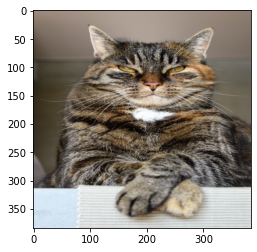

In [5]:
plt.imshow(HR_train[65])

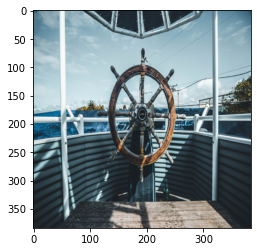

In [80]:
plt.imshow(HR_train[save_ind])

### Raw visualization of the low resolution and high resolution images 

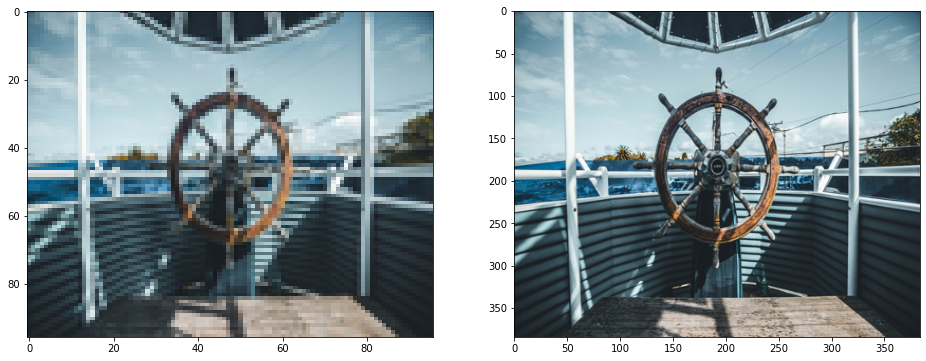

In [6]:
f, ax= plt.subplots(1,2, figsize=(16, 6))
ax[0].imshow(LR_train[save_ind], aspect='auto')
ax[1].imshow(HR_train[save_ind], aspect='auto')
plt.show()

### Importing Keras libraries on top of Tensorflow

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer

from tensorflow.keras.models import Model

In [8]:
#Dedining the input and output shapes
#Code Snippet taken from Kaggle

class SubpixelConv2D(Layer):
    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor

    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of '
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

In [9]:
#Generator
def get_G(input_shape):
    # w_init = tf.random_normal_initializer(stddev=0.02)
    g_init = tf.random_normal_initializer(1., 0.02)
    relu= Activation('relu')

    nin= Input(shape= input_shape)
    n= Conv2D(64, (3,3), padding='SAME', activation= 'relu',
                        kernel_initializer='HeNormal')(nin)
    temp= n


    # B residual blocks
    for i in range(3):
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)
        nn= relu(nn)
        nn= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn= BatchNormalization(gamma_initializer= g_init)(nn)

        nn= add([n, nn])
        n= nn

    n= Conv2D(64, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    n= add([n, temp])
    # B residual blacks end

    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)

    n= Conv2D(256, (3,3), padding='SAME', kernel_initializer='HeNormal')(n)
    n= SubpixelConv2D(upsampling_factor=2)(n)
    n= relu(n)

    nn= Conv2D(3, (1,1), padding='SAME', kernel_initializer='HeNormal', activation= 'tanh')(n)


    G = Model(inputs=nin, outputs=nn, name="generator")
    return G


# discriminator
def get_D(input_shape):

    g_init= tf.random_normal_initializer(1., 0.02)
    ly_relu= LeakyReLU(alpha= 0.2)
    df_dim = 16

    nin = Input(input_shape)
    n = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(nin)
    n= ly_relu(n)

    for i in range(2, 6):
        n = Conv2D(df_dim*(2**i),(4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(n)
        n= ly_relu(n)
        n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)
    temp= n

    n= Conv2D(df_dim*4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= ly_relu(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= Conv2D(df_dim*8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n= BatchNormalization(gamma_initializer= g_init)(n)

    n= add([n, temp])

    n= Flatten()(n)
    no= Dense(units=1, kernel_initializer='HeNormal', activation= 'sigmoid')(n)
    D= Model(inputs=nin, outputs=no, name="discriminator")

    return D


# VGG19
def get_vgg19():
    vgg= tf.keras.applications.VGG19( include_top=False, weights='imagenet', 
                                    input_tensor=None, input_shape=(384, 384, 3),
                                    pooling=None, classes=1000, classifier_activation='softmax' )

    inp= Input(shape=(384, 384, 3))
    x= vgg.layers[0](inp)
    for ly in vgg.layers[1:17]:
        x= ly(x)
    VGG19= Model(inp, x)

    return VGG19

In [10]:
G = get_G((96, 96, 3))
D = get_D((384, 384, 3))
vgg= get_vgg19()

In [11]:
# Optimizers
g_optimizer_init = tf.optimizers.Adam(lr_v)
g_optimizer = tf.optimizers.Adam(lr_v)
d_optimizer = tf.optimizers.Adam(lr_v)

In [56]:
n_step_epoch = round(n_epoch_init // batch_size)
tempArr = []
for epoch in range(n_epoch_init):
  i,j= ((epoch)*batch_size)%tot_sample, (((epoch+1))*batch_size)%tot_sample
  if j== 0:
    j= -1
  X, Y= LR_train[i: j], HR_train[i: j]
  with tf.GradientTape() as tape:
      ypred= G(X)
      mse_loss= tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, ypred), axis=-1))
      grad = tape.gradient(mse_loss, G.trainable_weights)
      g_optimizer_init.apply_gradients(zip(grad, G.trainable_weights))
        
  print("Epoch: [{}/{}] mse: {:.3f} ".format(
            epoch, n_epoch_init , mse_loss))
  tempArr.append(mse_loss)
  if epoch%10 ==0:
    img= G.predict(LR_train[np.newaxis, save_ind])[0]
    img= Image.fromarray(np.uint8(img*255))
    img.save(os.path.join(save_dir, 'init_g_{}.png'.format(epoch)))

Epoch: [0/50] step: mse: 0.008 
Epoch: [1/50] step: mse: 0.007 
Epoch: [2/50] step: mse: 0.014 
Epoch: [3/50] step: mse: 0.008 
Epoch: [4/50] step: mse: 0.010 
Epoch: [5/50] step: mse: 0.009 
Epoch: [6/50] step: mse: 0.006 
Epoch: [7/50] step: mse: 0.006 
Epoch: [8/50] step: mse: 0.013 
Epoch: [9/50] step: mse: 0.007 
Epoch: [10/50] step: mse: 0.006 
Epoch: [11/50] step: mse: 0.008 
Epoch: [12/50] step: mse: 0.006 
Epoch: [13/50] step: mse: 0.008 
Epoch: [14/50] step: mse: 0.007 
Epoch: [15/50] step: mse: 0.005 
Epoch: [16/50] step: mse: 0.009 
Epoch: [17/50] step: mse: 0.009 
Epoch: [18/50] step: mse: 0.010 
Epoch: [19/50] step: mse: 0.014 
Epoch: [20/50] step: mse: 0.008 
Epoch: [21/50] step: mse: 0.007 
Epoch: [22/50] step: mse: 0.014 
Epoch: [23/50] step: mse: 0.008 
Epoch: [24/50] step: mse: 0.010 
Epoch: [25/50] step: mse: 0.009 
Epoch: [26/50] step: mse: 0.006 
Epoch: [27/50] step: mse: 0.006 
Epoch: [28/50] step: mse: 0.013 
Epoch: [29/50] step: mse: 0.007 
Epoch: [30/50] step:

In [74]:
tempArr

[<tf.Tensor: shape=(), dtype=float32, numpy=0.007849091>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0069676684>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01425233>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008305595>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.010186307>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008936336>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0060967742>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0057881754>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.012910428>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0067547862>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0058619203>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008154203>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.006440015>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00838017>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0069242544>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0054334993>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.008881066>,
 <tf.Tens

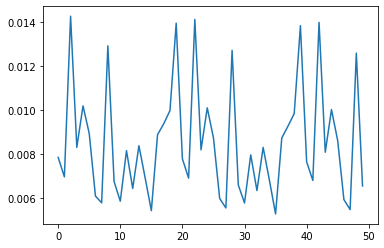

In [79]:
from matplotlib import pyplot as plt
plt.plot(tempArr)
plt.show()

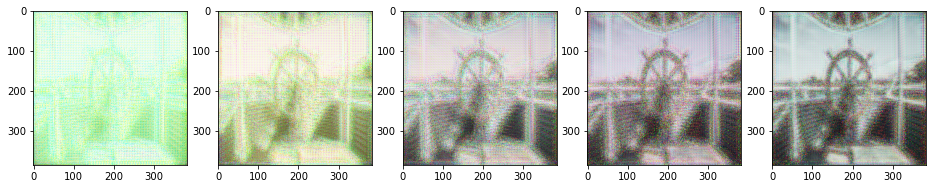

In [13]:
f, ax= plt.subplots(1,5, figsize=(16, 6))
for i, file in enumerate(glob.glob('./samples/init*')):
    img= load(file, shape=(384, 384))
    ax[i].imshow(img)
plt.show()    

In [14]:
n_epoch= n_epoch-200
for epoch in range(n_epoch):
        i,j= ((epoch)*batch_size)%tot_sample, (((epoch+1))*batch_size)%tot_sample
        if j== 0:
            j= -1
        X, Y= LR_train[i: j], HR_train[i: j]
        with tf.GradientTape(persistent=True) as tape:
            fake_img= G(X)
            fake_logits= D(fake_img)
            real_logits= D(Y)
            fake_feature= vgg(fake_img)
            real_feature= vgg(Y)

            #D. loss
            d_loss1= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits , tf.zeros_like(fake_logits)))
            d_loss2= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits,tf.ones_like(real_logits)))
            d_loss= d_loss1 + d_loss2

            #G. loss
            g_gan_loss= 2e-3*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits , tf.ones_like(fake_logits)))
            mse_loss=  2e-1* tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            vgg_loss = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1))
            g_loss = mse_loss + vgg_loss + g_gan_loss

            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))

        print("Epoch: [{}/{}] Discriminator loss: {:.3f}: Generator loss: {:.3f}".format(
                epoch, n_epoch , d_loss, g_loss))


        if epoch%20 ==0:
            img= G.predict(LR_train[np.newaxis, save_ind])[0]
            img= Image.fromarray(np.uint8(img*255))
            img.save(os.path.join(save_dir, 'train_g_{}.png'.format(epoch)))

Epoch: [0/300] step: D.loss: 1.703: G.loss: 0.012
Epoch: [1/300] step: D.loss: 1.006: G.loss: 0.018
Epoch: [2/300] step: D.loss: 1.006: G.loss: 0.015
Epoch: [3/300] step: D.loss: 1.006: G.loss: 0.011
Epoch: [4/300] step: D.loss: 1.006: G.loss: 0.013
Epoch: [5/300] step: D.loss: 1.006: G.loss: 0.010
Epoch: [6/300] step: D.loss: 1.006: G.loss: 0.008
Epoch: [7/300] step: D.loss: 1.006: G.loss: 0.007
Epoch: [8/300] step: D.loss: 1.006: G.loss: 0.011
Epoch: [9/300] step: D.loss: 1.006: G.loss: 0.008
Epoch: [10/300] step: D.loss: 1.006: G.loss: 0.006
Epoch: [11/300] step: D.loss: 1.006: G.loss: 0.008
Epoch: [12/300] step: D.loss: 1.006: G.loss: 0.006
Epoch: [13/300] step: D.loss: 1.006: G.loss: 0.008
Epoch: [14/300] step: D.loss: 1.006: G.loss: 0.006
Epoch: [15/300] step: D.loss: 1.006: G.loss: 0.006
Epoch: [16/300] step: D.loss: 1.006: G.loss: 0.008
Epoch: [17/300] step: D.loss: 1.006: G.loss: 0.008
Epoch: [18/300] step: D.loss: 1.006: G.loss: 0.007
Epoch: [19/300] step: D.loss: 1.006: G.lo

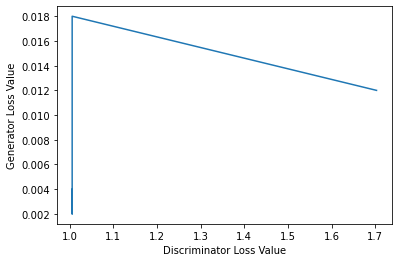

In [65]:
# Took hard values for plot as code took very long time to run
from matplotlib import pyplot as plt
plt.plot([1.703,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006,
1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006
,1.006], [0.012,
0.018,
0.015,
0.011,
0.013,
0.010,
0.008,
0.007,
0.011,
0.008,
0.006,
0.008,
0.006,
0.008,
0.006,
0.006,
0.008,
0.008,
0.007,
0.009,
0.007,
0.006,
0.009,
0.006,
0.006,
0.006,
0.005,
0.004,
0.007,
0.005,
0.004,
0.005,
0.004,
0.005,
0.004,
0.004,
0.006,
0.006,
0.005,
0.007,
0.005,
0.004,
0.007,
0.005,
0.005,
0.005,
0.004,
0.003,
0.006,
0.004,
0.003,
0.004,
0.004,
0.004,
0.004,
0.003,
0.005,
0.005,
0.004,
0.006,
0.004,
0.004,
0.006,
0.004,
0.004,
0.004,
0.003,
0.003,
0.005,
0.004,
0.003,
0.004,
0.003,
0.004,
0.003,
0.003,
0.004,
0.004,
0.004,
0.005,
0.004,
0.003,
0.005,
0.003,
0.004,
0.004,
0.003,
0.002,
0.005,
0.003,
0.003,
0.003,
0.003,
0.004,
0.003,
0.003,
0.004,
0.004,
0.004,
0.005,
0.003,
0.003,
0.005,
0.003,
0.004,
0.003,
0.003,
0.002,
0.004,
0.003,
0.002,
0.003,
0.003,
0.003,
0.003,
0.002,
0.004,
0.004,
0.003,
0.005,
0.003,
0.003,
0.005,
0.003,
0.004,
0.003,
0.002,
0.002,
0.004,
0.003,
0.002,
0.003,
0.003,
0.003,
0.003,
0.002,
0.003,
0.003,
0.003,
0.004,
0.003,
0.003,
0.004,
0.003,
0.003,
0.003,
0.002,
0.002,
0.004,
0.003,
0.002,
0.003,
0.003,
0.003,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.003,
0.003,
0.004,
0.003,
0.003,
0.003,
0.002,
0.002,
0.004,
0.003,
0.002,
0.003,
0.002,
0.003,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.003,
0.003,
0.004,
0.003,
0.003,
0.003,
0.002,
0.002,
0.004,
0.002,
0.002,
0.003,
0.002,
0.003,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.003,
0.002,
0.004,
0.003,
0.003,
0.003,
0.002,
0.002,
0.004,
0.002,
0.002,
0.003,
0.002,
0.003,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.002,
0.002,
0.004,
0.003,
0.003,
0.003,
0.002,
0.002,
0.004,
0.002,
0.002,
0.002,
0.002,
0.003,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.002,
0.002,
0.004,
0.002,
0.003,
0.003,
0.002,
0.002,
0.003,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.002,
0.002,
0.004,
0.002,
0.003,
0.003,
0.002,
0.002,
0.003,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.003,
0.003,
0.003,
0.004,
0.002,
0.002,
0.004,
0.002,
0.003,
0.003,
0.002,
0.002,
0.003,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.002,
0.003,
0.003,
0.004,])
plt.xlabel("Discriminator Loss Value")
plt.ylabel("Generator Loss Value")
plt.show()

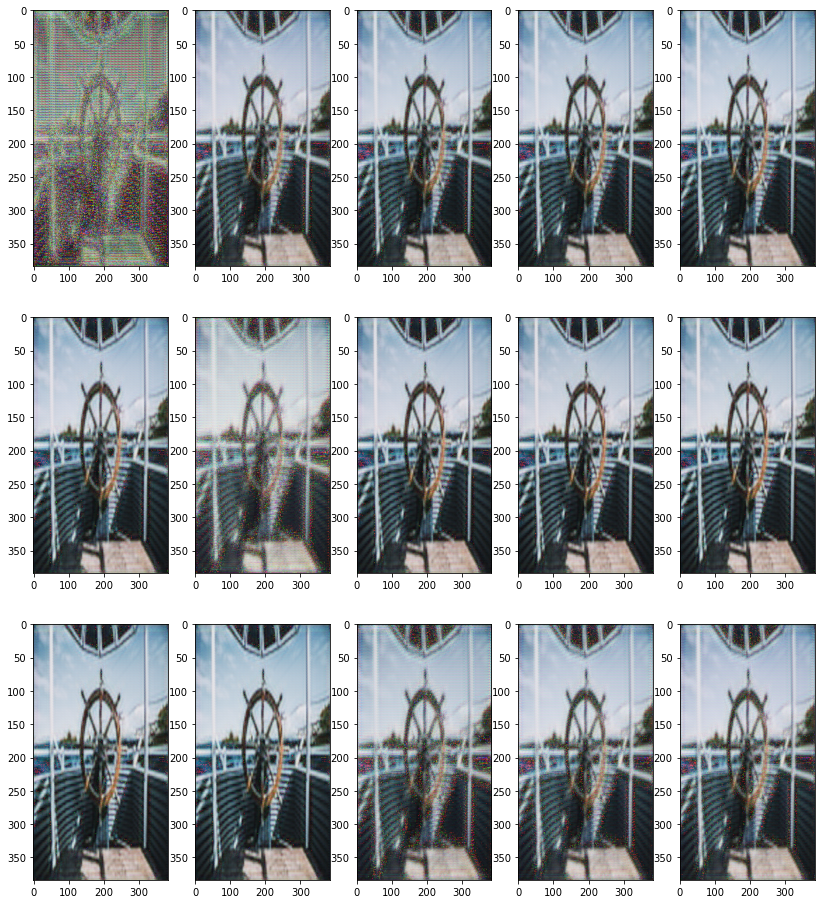

In [15]:
f, ax= plt.subplots(3,5, figsize=(14, 16))
for i, file in enumerate(glob.glob('./samples/train*')[:15]):
    img= load(file, shape=(384, 384))
    ax[i//5][i%5].imshow(img, aspect='auto')
plt.show()   

### Final Comarison of Low resolution image, Generated Image and high resolution image

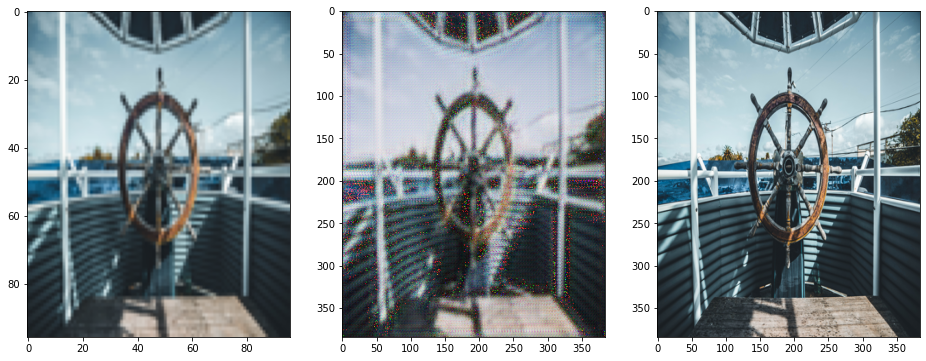

In [21]:
f, ax= plt.subplots(1,3, figsize=(16, 6))
ax[0].imshow(LR_train[save_ind], aspect='auto')
ax[1].imshow(load(glob.glob('./samples/train*')[-1], (384, 384)), aspect='auto')
ax[2].imshow(HR_train[save_ind], aspect='auto')
plt.show()

In [69]:
HR_train[save_ind]

array([[[0.17647059, 0.28627451, 0.34117647],
        [0.18431373, 0.29803922, 0.35294118],
        [0.18823529, 0.30196078, 0.35686275],
        ...,
        [0.17647059, 0.31372549, 0.38823529],
        [0.15686275, 0.29411765, 0.36862745],
        [0.15686275, 0.28627451, 0.35686275]],

       [[0.2       , 0.30980392, 0.36470588],
        [0.20392157, 0.31372549, 0.36862745],
        [0.21568627, 0.32941176, 0.39215686],
        ...,
        [0.18039216, 0.32156863, 0.39607843],
        [0.16862745, 0.30588235, 0.38039216],
        [0.16078431, 0.29803922, 0.37254902]],

       [[0.22352941, 0.33333333, 0.38823529],
        [0.21568627, 0.32941176, 0.38431373],
        [0.23137255, 0.34509804, 0.41176471],
        ...,
        [0.18431373, 0.32941176, 0.41176471],
        [0.17647059, 0.31372549, 0.38823529],
        [0.16862745, 0.30588235, 0.38039216]],

       ...,

       [[0.11372549, 0.1372549 , 0.15294118],
        [0.11372549, 0.14509804, 0.15686275],
        [0.11372549, 0

In [70]:
LR_train[save_ind]

array([[[0.21176471, 0.32941176, 0.38823529],
        [0.24705882, 0.37647059, 0.44313725],
        [0.4       , 0.52156863, 0.57647059],
        ...,
        [0.24313725, 0.39607843, 0.4745098 ],
        [0.21960784, 0.36862745, 0.44313725],
        [0.18039216, 0.32156863, 0.4       ]],

       [[0.29019608, 0.41568627, 0.47843137],
        [0.30980392, 0.44313725, 0.50980392],
        [0.37647059, 0.50980392, 0.56862745],
        ...,
        [0.25882353, 0.41960784, 0.49803922],
        [0.24705882, 0.39607843, 0.47843137],
        [0.21176471, 0.36078431, 0.44313725]],

       [[0.32156863, 0.45098039, 0.51764706],
        [0.34509804, 0.48235294, 0.54509804],
        [0.37254902, 0.51372549, 0.57647059],
        ...,
        [0.29019608, 0.45098039, 0.52941176],
        [0.27058824, 0.42745098, 0.50588235],
        [0.24313725, 0.4       , 0.47843137]],

       ...,

       [[0.09803922, 0.11764706, 0.13333333],
        [0.10980392, 0.13333333, 0.14509804],
        [0.1254902 , 0

In [87]:
#plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(load(glob.glob('./samples/train*')[-1], (384, 384)), 0, 255),
    tf.clip_by_value(HR_train[save_ind], 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR Achieved: 17.039289
